# Costruzione di un paresr ricorsivo discendente

In [ ]:
from textwrap import dedent, indent

from liblet import (
    Grammar, 
    Derivation, 
    ProductionGraph, 
    show_calls, 
    iter2table
)

## Eliminazione della ricorsione

In [ ]:
# grammatica per l'aritmetica col + e il - 

# versione ricorsiva

"""
E -> E + T | E - T | T
T -> t
""";

In [ ]:
# versione non ricorsiva

"""
E -> Eh Ets | Eh
Eh -> T
Ets -> Et Ets | Et
Et -> + T | - T
T -> t
""";

In [ ]:
# versione prefix-free

G = Grammar.from_string("""
E -> Eh Ets | Eh #
Eh -> T
Ets -> Et Ets | Et #
Et -> + T | - T
T -> t
""")
G

# Ets => Et^+ #
# E => Eh Ets * #

Grammar(N={E, Eh, Et, Ets, T}, T={#, +, -, t}, P=(E -> Eh Ets, E -> Eh #, Eh -> T, Ets -> Et Ets, Ets -> Et #, Et -> + T, Et -> - T, T -> t), S=E)

## Costruzione manuale del parser

Costruiamo una funzione `match` (a partire dalla grammatica $G$) che su input $X$ e $\alpha\beta$ restituisce una coppia $(b, \beta)$ dove $b$ è `True`  se e solo se il simbolo $X \in N \cup T$ è tale che $X\stackrel{*}{\to}\alpha$.

In [ ]:
@show_calls(True)
def match(X, rest):

    if X in G.T:
        
        if rest and rest[0] == X: return True, rest[1:]
        return False, rest

    elif X == 'T': # T -> t

        return match('t', rest)

    elif X == 'Eh': # Eh -> T

        return match('T', rest)
    
    elif X == 'Et': # Et -> + T | - T

        s, r = match('+', rest)
        if s: return match('T', r)
        s, r = match('-', rest)
        if s: return match('T', r)
        return False, rest        

    elif X == 'Ets': # Ets -> Et Ets | Et #

        s0, r0 = match('Et', rest)
        if s0:
            s1, r1 = match('#', r0)
            if s1: return True, r1
            return match('Ets', r0)
        return False, rest        
    
    elif X == 'E': # E -> Eh Ets | Eh #

        s0, r0 = match('Eh', rest)
        if s0:
            s1, r1 = match('#', r0)
            if s1: return True, r1
            return match('Ets', r0)
        return False, rest        


Decidere se $\omega\in L(G)$ equivale a chiedersi se su input $E$ e $\omega$ la funzione restituisce (`True`, $\varepsilon$).

In [ ]:
INPUT = list('t+t-t#') # le parole sono liste di stringhe…

match('E', INPUT)

┌match('E', ['t', '+', 't', '-', 't', '#'])
│┌match('Eh', ['t', '+', 't', '-', 't', '#'])
││┌match('T', ['t', '+', 't', '-', 't', '#'])
│││┌match('t', ['t', '+', 't', '-', 't', '#'])
│││└─ (True, ['+', 't', '-', 't', '#'])
││└─ (True, ['+', 't', '-', 't', '#'])
│└─ (True, ['+', 't', '-', 't', '#'])
│┌match('#', ['+', 't', '-', 't', '#'])
│└─ (False, ['+', 't', '-', 't', '#'])
│┌match('Ets', ['+', 't', '-', 't', '#'])
││┌match('Et', ['+', 't', '-', 't', '#'])
│││┌match('+', ['+', 't', '-', 't', '#'])
│││└─ (True, ['t', '-', 't', '#'])
│││┌match('T', ['t', '-', 't', '#'])
││││┌match('t', ['t', '-', 't', '#'])
││││└─ (True, ['-', 't', '#'])
│││└─ (True, ['-', 't', '#'])
││└─ (True, ['-', 't', '#'])
││┌match('#', ['-', 't', '#'])
││└─ (False, ['-', 't', '#'])
││┌match('Ets', ['-', 't', '#'])
│││┌match('Et', ['-', 't', '#'])
││││┌match('+', ['-', 't', '#'])
││││└─ (False, ['-', 't', '#'])
││││┌match('-', ['-', 't', '#'])
││││└─ (True, ['t', '#'])
││││┌match('T', ['t', '#'])
│││││┌match('t',

(True, [])

### Ricostruire l'albero di parsing

Modifichiamo la funzione `match` perché restituisca anche la sequenza delle derivazioni leftmost che conducono al riconoscimento.

In [ ]:
# servono i numeri di produzione

iter2table(G.P)

In [ ]:
# ora match restituisce: succ, rest, steps

@show_calls(True)
def match(X, rest): 

    if X in G.T:
        
        if rest and rest[0] == X: return True, rest[1:]
        return False, rest

    elif X == 'T':

        s, r = match('t', rest)
        if s: return True, r, [7]
        
    elif X == 'Eh':
        
        s, r, p = match('T', rest)
        if s: return True, r, [2] + p

    elif X == 'Et':
        
        s, r = match('+', rest)
        if s:
            s, r, p = match('T', r)
            if s: return True, r, [5] + p
        s, r = match('-', rest)
        if s: 
            s, r, p = match('T', r)
            if s: return True, r, [6] + p
            
    elif X == 'Ets':
        
        s0, r0, p0 = match('Et', rest)
        if s0:
            s1, r1 = match('#', r0)
            if s1: return True, r1, [4] + p0
            s2, r2, p2 = match('Ets', r0)
            if s2: return True, r2, [3] + p0 + p2

    elif X == 'E':

        s0, r0, p0 = match('Eh', rest)
        if s0:
            s1, r1 = match('#', r0)
            if s1: return True, r1, [1] + p0
            s2, r2, p2 = match('Ets', r0)
            if s2: return True, r2, [0] + p0 + p2

    return False, rest, []        

In [ ]:
# testiamo lo stesso input

_, _, steps = match('E', INPUT)
steps

┌match('E', ['t', '+', 't', '-', 't', '#'])
│┌match('Eh', ['t', '+', 't', '-', 't', '#'])
││┌match('T', ['t', '+', 't', '-', 't', '#'])
│││┌match('t', ['t', '+', 't', '-', 't', '#'])
│││└─ (True, ['+', 't', '-', 't', '#'])
││└─ (True, ['+', 't', '-', 't', '#'], [7])
│└─ (True, ['+', 't', '-', 't', '#'], [2, 7])
│┌match('#', ['+', 't', '-', 't', '#'])
│└─ (False, ['+', 't', '-', 't', '#'])
│┌match('Ets', ['+', 't', '-', 't', '#'])
││┌match('Et', ['+', 't', '-', 't', '#'])
│││┌match('+', ['+', 't', '-', 't', '#'])
│││└─ (True, ['t', '-', 't', '#'])
│││┌match('T', ['t', '-', 't', '#'])
││││┌match('t', ['t', '-', 't', '#'])
││││└─ (True, ['-', 't', '#'])
│││└─ (True, ['-', 't', '#'], [7])
││└─ (True, ['-', 't', '#'], [5, 7])
││┌match('#', ['-', 't', '#'])
││└─ (False, ['-', 't', '#'])
││┌match('Ets', ['-', 't', '#'])
│││┌match('Et', ['-', 't', '#'])
││││┌match('+', ['-', 't', '#'])
││││└─ (False, ['-', 't', '#'])
││││┌match('-', ['-', 't', '#'])
││││└─ (True, ['t', '#'])
││││┌match('T', ['

[0, 2, 7, 3, 5, 7, 4, 6, 7]

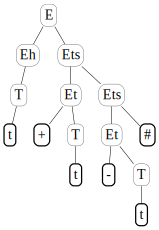

In [ ]:
# graficamente

d = Derivation(G).leftmost(steps)
ProductionGraph(d)

## Generazione automatica del parser

Iniziamo con l'osservare che gli `if` della soluzione manuale sono prodotti, uno per ciascun simbolo, considerando in sequenza le possibili alternative (lati destri delle produzioni) e restituendo successo al primo tentativo valido.

Un esmepio è il simbolo `Ets` le cui due alternative sono `Et Ets` e `Et #`… supponiamo di scaricarne la soluzione a due funzioni denominate `Ets_alt0` e `Ets_alt0` che definiremo in seguito.

In [ ]:
def match(X, rest):
    
    # ...
    
    if X == 'Ets':
        succ_alt, rest_alt = Ets_alt0(rest)
        if succ_alt: return True, rest_alt
        succ_alt, rest_alt = Ets_alt1(rest)
        if succ_alt: return True, rest_alt
        return False, rest

    # ...

Ciascuna alternativa e valutata considerando in sequenza i simboli di cui è costituita, vediamo ad esempio `Et Ets`

In [ ]:
def Ets_alt0(rest):
    succ, rest = match('Et', rest)
    if not succ: return False, rest
    succ, rest = match('Ets', rest)
    if not succ: return False, rest
    return True, rest

e similmente `Et #` 

In [ ]:
def Ets_alt1(rest):
    succ, rest = match('Et', rest)
    if not succ: return False, rest
    succ, rest = match('#', rest)
    if not succ: return False, rest
    return True, rest

Non è difficile scrivere una funzione che, data $G$ come input, produca il testo sorgente della funzione `match` procedendo come sopra.

Ci servono due funzioni di utlità: la prima per indentare un blocco di testo al livello di intentazione specificato, la seconda per tradurre il codice sorgente di una funzione Python di nome `match` in codice eseguibile.

In [ ]:
def indent_at(level, source):
    return indent(dedent(source), '  ' * level).strip('\n')

def make_match(source):
    glb = {'show_calls': show_calls}
    exec(source, glb)
    return glb['match']       

Siamo pronti per procedere, useremo le [f-stringhe](https://docs.python.org/3/reference/lexical_analysis.html#f-strings) per maggior compattezza, scriviamo una funzione che data $G$ restituisca il sorgente di `match` costruita secondo i criteri precedentemente espressi.

In [ ]:
def make_match_source(G):
    
    # prima le funzioni X_altN
    
    defs = []
    for A in G.N:
        for n, α in enumerate(G.alternatives(A)):
            # la funzione "{A}_alt{n}"
            defs.append(f'def {A}_alt{n}(rest):')
            for X in α: 
                # una coppia di linee per ogni simbolo
                defs.append(indent_at(1, f'''
                  succ, rest = match('{X}', rest)
                  if not succ: return False, rest
                '''))
            defs.append(indent_at(1,'return True, rest'))
    
    # poi gli if, uno per terminale
    
    ifs = []
    for A in G.N:
        # l'if "X == '{A}'"
        ifs.append(f"if X == '{A}':")
        for n, α in enumerate(G.alternatives(A)): 
            # una coppia di linee, una per alternativa
            ifs.append(indent_at(1, f'''
                succ_alt, rest_alt = {A}_alt{n}(rest)
                if succ_alt: return True, rest_alt
            '''))
        ifs.append(indent_at(1,'return False, rest'))

    # in fine i terminali
    
    ifs.append(indent_at(0, f'''
        if X in {G.T}:
          if rest and rest[0] == X: return True, rest[1:]
          return False, rest
    '''))
    
    # e ora mettiamo tutto assieme 
    
    match = '\n'.join((
        indent_at(0, '''
            @show_calls(True)
            def match(X, rest):
        '''), 
        indent_at(1, '\n'.join(defs)), 
        indent_at(1, '\n'.join(ifs))))
        
    return match

Siamo pronti, generiamo (e stampiamo) il sorgente

In [ ]:
source = make_match_source(G) # G è la grammatica prefix-free dell'inizio
print(source)

@show_calls(True)
def match(X, rest):
  def Eh_alt0(rest):
    succ, rest = match('T', rest)
    if not succ: return False, rest
    return True, rest
  def Et_alt0(rest):
    succ, rest = match('+', rest)
    if not succ: return False, rest
    succ, rest = match('T', rest)
    if not succ: return False, rest
    return True, rest
  def Et_alt1(rest):
    succ, rest = match('-', rest)
    if not succ: return False, rest
    succ, rest = match('T', rest)
    if not succ: return False, rest
    return True, rest
  def Ets_alt0(rest):
    succ, rest = match('Et', rest)
    if not succ: return False, rest
    succ, rest = match('Ets', rest)
    if not succ: return False, rest
    return True, rest
  def Ets_alt1(rest):
    succ, rest = match('Et', rest)
    if not succ: return False, rest
    succ, rest = match('#', rest)
    if not succ: return False, rest
    return True, rest
  def T_alt0(rest):
    succ, rest = match('t', rest)
    if not succ: return False, rest
    return True, rest

E ora rendiamolo eseguibile e testiamolo sull'input

In [ ]:
match = make_match(source)

match('E', 't+t-t#')

┌match('E', 't+t-t#')
│┌match('Eh', 't+t-t#')
││┌match('T', 't+t-t#')
│││┌match('t', 't+t-t#')
│││└─ (True, '+t-t#')
││└─ (True, '+t-t#')
│└─ (True, '+t-t#')
│┌match('Ets', '+t-t#')
││┌match('Et', '+t-t#')
│││┌match('+', '+t-t#')
│││└─ (True, 't-t#')
│││┌match('T', 't-t#')
││││┌match('t', 't-t#')
││││└─ (True, '-t#')
│││└─ (True, '-t#')
││└─ (True, '-t#')
││┌match('Ets', '-t#')
│││┌match('Et', '-t#')
││││┌match('+', '-t#')
││││└─ (False, '-t#')
││││┌match('-', '-t#')
││││└─ (True, 't#')
││││┌match('T', 't#')
│││││┌match('t', 't#')
│││││└─ (True, '#')
││││└─ (True, '#')
│││└─ (True, '#')
│││┌match('Ets', '#')
││││┌match('Et', '#')
│││││┌match('+', '#')
│││││└─ (False, '#')
│││││┌match('-', '#')
│││││└─ (False, '#')
││││└─ (False, '#')
││││┌match('Et', '#')
│││││┌match('+', '#')
│││││└─ (False, '#')
│││││┌match('-', '#')
│││││└─ (False, '#')
││││└─ (False, '#')
│││└─ (False, '#')
│││┌match('Et', '-t#')
││││┌match('+', '-t#')
││││└─ (False, '-t#')
││││┌match('-', '-t#')
││││└─ (True, 't#'

(True, '')

## Un caso concreto non prefix-free

Cosa succede se $G$ non è *prefix-free*?

In [ ]:
# una grammatica non prefix-free (L = {a, ab})

G = Grammar.from_string("""
S -> a | B
B -> a b
""")
G

Grammar(N={B, S}, T={a, b}, P=(S -> a, S -> B, B -> a b), S=S)

In [ ]:
# costruiamo il parser e tentiamo il parse

source = make_match_source(G)
match = make_match(source)
match('S', 'ab')

┌match('S', 'ab')
│┌match('a', 'ab')
│└─ (True, 'b')
└─ (True, 'b')


(True, 'b')

Questo è un fallimento, non è stata considerata la seconda produzione ed in fatti è "avanzata" la `b`. Questo avviene perché il parser valuta in sequenza le alterniative e procede nella ricorsione al primo successo (non investigando se ci siano altri possibili successi in altre alternative).

## <span style="color: red">Esercizio per casa</span>

Modificate `make_match_source` perché la `match` che essa produce restituisca anche l'elenco di produzioni della derivazione *leftmost* corrisondente al parsing effettuato. 